# Supporting Information for Life cycle greenhouse gas reductions from coal power plant upgrades and biomass cofiring: Python Code

Greg Schivley<sup>1</sup>*, Wesley W. Ingwersen<sup>2</sup>, Joe Marriott<sup>1</sup>, Troy R. Hawkins<sup>3</sup>, Timothy J. Skone<sup>4</sup>

<sup>1</sup> Booz Allen Hamilton, Pittsburgh, PA, USA  
<sup>2</sup> National Risk Management Research Laboratory, Office of Research and Development, US Environmental Protection Agency, Cincinnati, OH USA  
<sup>3</sup> Enviance, Inc., Carlsbad, CA USA  
<sup>4</sup> National Energy Technology Laboratory, US Department of Energy, Pittsburgh, PA USA

Email: schivley_greg@bah.com

## Description

This SI document presents Python code used for numerical calculations in the format of an IPython notebook. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import interp1d
from scipy.signal import fftconvolve
from scipy.integrate import cumtrapz
import seaborn as sns
sns.set_palette('colorblind')

#### Radiative efficiencies of each gas

In [2]:
co2_re, ch4_re = 1.7517E-15, 1.2767E-13 * 1.65
n2o_re, sf6_re = 3.8477E-13, 2.0097E-11

#### Impulse response functions (IRF) for CO<sub>2</sub>, CH<sub>4</sub>, and N<sub>2</sub>O

Source: (1)

In [3]:
# AR5 2013 CO2 IRF values
a0, a1, a2, a3 = 0.2173, 0.224, 0.2824, 0.2763
tau1, tau2, tau3 = 394.4, 36.54, 4.304

#CO2 response function
def f0(t):
    return a0
def f1(t):
    return a1*np.exp(-t/tau1)
def f2(t):
    return a2*np.exp(-t/tau2)
def f3(t):
    return a3*np.exp(-t/tau3)
def CO2_AR5(t):
    return f0(t) + f1(t) + f2(t) + f3(t)

#Methane response fuction
CH4tau = 12.4
def CH4_AR5(t):
    return np.exp(-t/CH4tau)

#N2O response fuction
N2Otau = 121
def N2O_AR5(t):
    return np.exp(-t/N2Otau)

#### CO<sub>2</sub> CRF calculation

In [4]:
def CO2_crf(emission, years, tstep=0.01, kind='linear'):
    """Transforms an array of CO2 emissions into radiative forcing with user-
    defined time-step.

    emission: an array of emissions, should be same size as years
    years: an array of years at which the emissions take place
    tstep: time step to be used in the calculations
    kind: the type of interpolation to use; can be linear or cubic
    """
# Emission is a series of emission numbers, years should match up with it
# The interpolation is for cases where irregular intervals exist between emission values
    if min(years) > 0:
        years = years - min(years)

    end = max(years)
    f = interp1d(years, emission, kind=kind)
    time = np.linspace(years[0], end, end/tstep + 1)
    inter_emissions = f(time)
    atmos = np.resize(fftconvolve(CO2_AR5(time), inter_emissions), time.size) * tstep
    rf = atmos * co2_re
    crf = cumtrapz(rf, dx = tstep, initial = 0)
    fil = np.zeros_like(time, dtype=bool)
    for i in time:
        if i == int(i):
            fil[i/tstep] = True

    return crf[fil]

#### CH<sub>4</sub> CRF

The CRF for methane takes several indirect effects into account:

- Decay of methane to CO<sub>2</sub> at the end of its life.
- Climate-carbon feedbacks, where increases in temperature from the methane emissions lead to additional CO<sub>2</sub> in the atmosphere. Temperature increases are calculated using equations from Boucher (2008).

In [5]:
def ch42co2(t, alpha=0.51):
    """As methane decays some fraction is converted to CO2. This function is
    from Boucher et al (2). By default it converts 51%. The convolution of this
    function with the methane emission profile gives the CO2 emission profile.

    t: time
    alpha: fraction of methane converted to CO2
    """
    ch4tau = 12.4
    return 1/ch4tau * alpha * np.exp(-t/ch4tau)

def AR5_GTP(t):
    c1, c2, d1, d2 = 0.631, 0.429, 8.4, 409.5
    """ The default response function for radiative forcing from AR5. Source is 
    Boucher and Reddy (3). ECR is 3.9K, which is on the high side.
    Convolve with radiative forcing to get temperature.
    """
    return c1/d1*np.exp(-t/d1) + c2/d2*np.exp(-t/d2)

def CH4_cc_tempforrf(emission, years, tstep=0.01, kind='linear', decay=True):
    """Transforms an array of methane emissions into temperature with user-defined
    time-step. Default temperature IRF is from AR5, use 'Alt_low' or 'Alt_high'
    for a sensitivity test.

    emission: an array of emissions, should be same size as years
    years: an array of years at which the emissions take place
    tstep: time step to be used in the calculations
    kind: the type of interpolation to use; can be linear or cubic
    source: the source of parameters for the temperature IRF. default is AR5,
    'Alt', 'Alt_low', and 'Alt_high' are also options.
    decay: a boolean variable for if methane decay to CO2 should be included
    """
# Emission is a series of emission numbers, years should match up with it
# The interpolation is for cases where irregular intervals exist between emission values
    if min(years) > 0:
        years = years - min(years)

    end = max(years)
    f = interp1d(years, emission, kind=kind)
    time = np.linspace(years[0], end, end/tstep + 1)
    ch4_inter_emissions = f(time)
    ch4_atmos = np.resize(fftconvolve(CH4_AR5(time), ch4_inter_emissions),
                          time.size) * tstep
    co2 = np.resize(fftconvolve(ch42co2(time), ch4_inter_emissions),
                    time.size) * tstep
    co2_atmos = np.resize(fftconvolve(CO2_AR5(time), co2),
                          time.size) * tstep
    if decay == True:
         rf = ch4_atmos * ch4_re + co2_atmos * co2_re
    else:
        rf = ch4_atmos * ch4_re
    temp = np.resize(fftconvolve(AR5_GTP(time), rf), time.size) * tstep

    return temp

def CH4_crf_cc(emission, years, tstep=0.01, kind='linear'):
    """Transforms an array of methane emissions into radiative forcing with user-defined
    time-step.

    emission: an array of emissions, should be same size as years
    years: an array of years at which the emissions take place
    tstep: time step to be used in the calculations
    kind: the type of interpolation to use; can be linear or cubic
    """
# Gamma is 1Gt carbon per K temp increase from Collins et al.(4)
    gamma = (44.0/12.0) * 10**12

# Emission is a series of emission numbers, years should match up with it
# The interpolation is for cases where irregular intervals exist between emission values
    if min(years) > 0:
        years = years - min(years)

    end = max(years)
    fch4 = interp1d(years, emission, kind=kind)
    time = np.linspace(years[0], end, end/tstep + 1)
    ch4_inter_emissions = fch4(time)
    ch4_atmos = np.resize(fftconvolve(CH4_AR5(time), ch4_inter_emissions),
                          time.size) * tstep
    co2 = 44.0/16.0 * np.resize(fftconvolve(ch42co2(time), ch4_inter_emissions),
                    time.size) * tstep
    co2_atmos = np.resize(fftconvolve(CO2_AR5(time), co2),
                          time.size) * tstep
    cc_co2 = CH4_cc_tempforrf(emission, years) * gamma
    cc_co2_atmos = np.resize(fftconvolve(CO2_AR5(time), cc_co2),
                          time.size) * tstep
    rf = ch4_atmos * ch4_re + (co2_atmos + cc_co2_atmos) * co2_re
    crf = cumtrapz(rf, dx = tstep, initial = 0)
    fil = np.zeros_like(time, dtype=bool)
    for i in time:
        if i == int(i):
            fil[i/tstep] = True

    return crf[fil]

def CH4_nonfossil_crf(emission, years, tstep=0.01, kind='linear'):
    """Transforms an array of methane emissions into radiative forcing with user-defined
    time-step.

    emission: an array of emissions, should be same size as years
    years: an array of years at which the emissions take place
    tstep: time step to be used in the calculations
    kind: the type of interpolation to use; can be linear or cubic
    """
# Gamma is 1Gt carbon per K temp increase from Collins et al (4)

    gamma = (44.0/12.0) * 10**12

    if min(years) > 0:
        years = years - min(years)

# Emission is a series of emission numbers, years should match up with it
# The interpolation is for cases where irregular intervals exist between emission values
    end = max(years)
    fch4 = interp1d(years, emission, kind=kind)
    time = np.linspace(years[0], end, end/tstep + 1)
    ch4_inter_emissions = fch4(time)
    ch4_atmos = np.resize(fftconvolve(CH4_AR5(time), ch4_inter_emissions),
                          time.size) * tstep
    co2 = 44.0/16.0 * np.resize(fftconvolve(ch42co2(time), ch4_inter_emissions),
                    time.size) * tstep
    co2_atmos = np.resize(fftconvolve(CO2_AR5(time), co2),
                          time.size) * tstep
    cc_co2 = CH4_cc_tempforrf(emission, years) * gamma
    cc_co2_atmos = np.resize(fftconvolve(CO2_AR5(time), cc_co2),
                          time.size) * tstep
    rf = ch4_atmos * ch4_re #+ (co2_atmos) * co2_re
    crf = cumtrapz(rf, dx = tstep, initial = 0)
    fil = np.zeros_like(time, dtype=bool)
    for i in time:
        if i == int(i):
            fil[i/tstep] = True

    return crf[fil]

def CH4_crf(emission, years, tstep=0.01, kind='linear'):
    """Transforms an array of methane emissions into radiative forcing with user-defined
    time-step.

    emission: an array of emissions, should be same size as years
    years: an array of years at which the emissions take place
    tstep: time step to be used in the calculations
    kind: the type of interpolation to use; can be linear or cubic
    """
# Gamma is 1Gt carbon per K temp increase from Collins et al.(4)
    gamma = (44.0/12.0) * 10**12
    
# Emission is a series of emission numbers, years should match up with it
# The interpolation is for cases where irregular intervals exist between emission values
    if min(years) > 0:
        years = years - min(years)

    end = max(years)
    fch4 = interp1d(years, emission, kind=kind)
    time = np.linspace(years[0], end, end/tstep + 1)
    ch4_inter_emissions = fch4(time)
    ch4_atmos = np.resize(fftconvolve(CH4_AR5(time), ch4_inter_emissions),
                          time.size) * tstep
    co2 = 44.0/16.0 * np.resize(fftconvolve(ch42co2(time), ch4_inter_emissions),
                    time.size) * tstep
    co2_atmos = np.resize(fftconvolve(CO2_AR5(time), co2),
                          time.size) * tstep
    cc_co2 = CH4_cc_tempforrf(emission, years) * gamma
    cc_co2_atmos = np.resize(fftconvolve(CO2_AR5(time), cc_co2),
                          time.size) * tstep
    rf = ch4_atmos * ch4_re + (co2_atmos) * co2_re
    crf = cumtrapz(rf, dx = tstep, initial = 0)
    fil = np.zeros_like(time, dtype=bool)
    for i in time:
        if i == int(i):
            fil[i/tstep] = True

    return crf[fil]

#### N<sub>2</sub>O CRF

In [15]:
def N2O_cc_tempforrf(emission, years, tstep=0.01, kind='linear'):
    """Transforms an array of N2O emissions into temperature with user-defined
    time-step. Default temperature IRF is from AR5, use 'Alt_low' or 'Alt_high'
    for a sensitivity test.

    emission: an array of emissions, should be same size as years
    years: an array of years at which the emissions take place
    tstep: time step to be used in the calculations
    kind: the type of interpolation to use; can be linear or cubic
    source: the source of parameters for the temperature IRF. default is AR5,
    'Alt', 'Alt_low', and 'Alt_high' are also options.
    """
# Emission is a series of emission numbers, years should match up with it
# The interpolation is for cases where irregular intervals exist between emission values
    if min(years) > 0:
        years = years - min(years)

    end = max(years)
    f = interp1d(years, emission, kind=kind)
    time = np.linspace(years[0], end, end/tstep + 1)
    n2o_inter_emissions = f(time)
    n2o_atmos = np.resize(fftconvolve(N2O_AR5(time), n2o_inter_emissions),
                          time.size) * tstep
    rf = n2o_atmos * n2o_re
    temp = np.resize(fftconvolve(AR5_GTP(time), rf), time.size) * tstep

    fil = np.zeros_like(time, dtype=bool)
    for i in time:
        if i == int(i):
            fil[i/tstep] = True

    return temp

def N2O_crf_cc(emission, years, tstep=0.01, kind='linear'):
    """Transforms an array of N2O emissions into cumulative radiative forcing 
    with user-defined time-step, accounting for climate-carbon feedbacks.

    emission: an array of emissions, should be same size as years
    years: an array of years at which the emissions take place
    tstep: time step to be used in the calculations
    kind: the type of interpolation to use; can be linear or cubic
    """
# Gamma is 1Gt carbon per K temp increase from Collins et al.(4)
    gamma = (44.0/12.0) * 10**12

# Emission is a series of emission numbers, years should match up with it
# The interpolation is for cases where irregular intervals exist between emission values
    if min(years) > 0:
        years = years - min(years)

    end = max(years)
    fn2o = interp1d(years, emission, kind=kind)
    time = np.linspace(years[0], end, end/tstep + 1)
    n2o_inter_emissions = fn2o(time)
    n2o_atmos = np.resize(fftconvolve(N2O_AR5(time), n2o_inter_emissions),
                          time.size) * tstep
    cc_co2 = N2O_cc_tempforrf(emission, years) * gamma
    cc_co2_atmos = np.resize(fftconvolve(CO2_AR5(time), cc_co2),
                          time.size) * tstep
    
    #From AR5 Ch.8 SM, reduction of 36 molecules CH4 for every 100 N2O emitted.
    #This is more accurate when done on a mass basis
    delta_ch4 = n2o_inter_emissions * -0.36
    
    rf = n2o_atmos * n2o_re
    crf = cumtrapz(rf, dx = tstep, initial = 0) 
    fil = np.zeros_like(time, dtype=bool)
    for i in time:
        if i == int(i):
            fil[i/tstep] = True

    return crf[fil] + CH4_crf_cc(delta_ch4, time)

def N2O_crf(emission, years, tstep=0.01, kind='linear'):
    """Transforms an array of N2O emissions into cumulative radiative forcing 
    with user-defined time-step, accounting for climate-carbon feedbacks.

    emission: an array of emissions, should be same size as years
    years: an array of years at which the emissions take place
    tstep: time step to be used in the calculations
    kind: the type of interpolation to use; can be linear or cubic
    """
# Gamma is 1Gt carbon per K temp increase from Collins et al.(4)
    gamma = (44.0/12.0) * 10**12

# Emission is a series of emission numbers, years should match up with it
# The interpolation is for cases where irregular intervals exist between emission values
    if min(years) > 0:
        years = years - min(years)

    end = max(years)
    fn2o = interp1d(years, emission, kind=kind)
    time = np.linspace(years[0], end, end/tstep + 1)
    n2o_inter_emissions = fn2o(time)
    n2o_atmos = np.resize(fftconvolve(N2O_AR5(time), n2o_inter_emissions),
                          time.size) * tstep
    cc_co2 = N2O_cc_tempforrf(emission, years) * gamma
    cc_co2_atmos = np.resize(fftconvolve(CO2_AR5(time), cc_co2),
                          time.size) * tstep
    
    #From AR5 Ch.8 SM, reduction of 36 molecules CH4 for every 100 N2O emitted
    delta_ch4 = n2o_inter_emissions * -0.36
    
    rf = n2o_atmos * n2o_re #+ (cc_co2_atmos) * co2_re
    crf = cumtrapz(rf, dx = tstep, initial = 0) 
    fil = np.zeros_like(time, dtype=bool)
    for i in time:
        if i == int(i):
            fil[i/tstep] = True

    return crf[fil] + CH4_crf(delta_ch4, time)

In [16]:
end = 200
tstep = 0.01
time = np.linspace(0, end, num=end/tstep+1)
emission_length = {'pulse' : 0.01,
        '1' : 1,
        '3' : 3,
        '19' : 19,
        '30' : 30,
        '60' : 60,
        '80' : 80}

### Calculation of CH<sub>4</sub> cumulative forcing - multiple emission time frames

In [17]:
emission, co2_crf, ch4_crf, ch4_cc_crf, n2o_crf, n2o_cc_crf = {}, {}, {}, {}, {}, {}

for life in list(emission_length.keys()):
    emission[life] = np.ones_like(time) / tstep
    emission[life][emission_length[life]/tstep:] = 0
    
    ch4_cc_crf[life] = CH4_crf_cc(emission[life], time)
    ch4_crf[life] = CH4_crf(emission[life], time)
    n2o_cc_crf[life] = N2O_crf_cc(emission[life], time)
    n2o_crf[life] = N2O_crf(emission[life], time)
    co2_crf[life] = CO2_crf(emission[life], time)

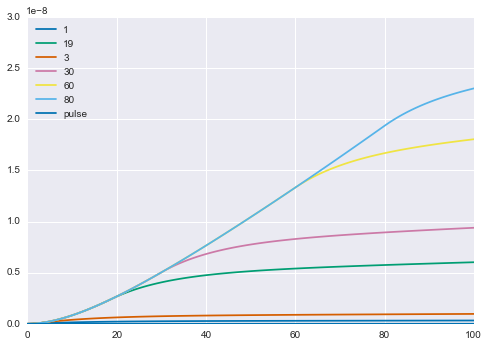

In [10]:
ch4_crf_cc_df = pd.DataFrame(ch4_cc_crf)
ch4_crf_cc_df.plot(xlim=(0,100))

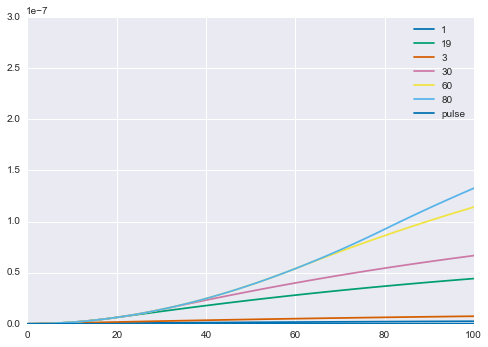

In [11]:
n2o_crf_df = pd.DataFrame(n2o_cc_crf)
n2o_crf_df.plot(xlim=(0,100))

In [7]:
writer = pd.ExcelWriter('EPA Methane forcing.xlsx')
ch4_cc_crf_df.to_excel(writer)
writer.save()

### Calculation of N<sub>2</sub>O cumulative forcing - 35 years of emissions

In [3]:
n2o = np.ones_like(time)
n2o[35/tstep+1 :] = 0
n2o_crf = N2O_crf_cc(n2o, time)

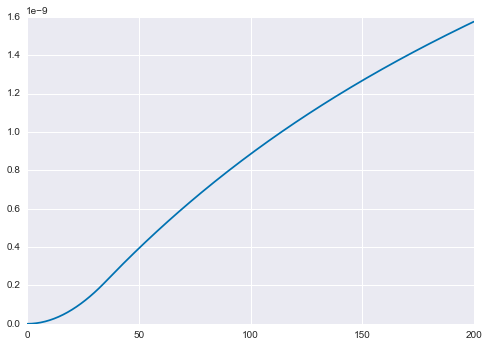

In [4]:
plt.plot(n2o_crf)

In [5]:
writer = pd.ExcelWriter('EPA N2O forcing 35 years.xlsx')
pd.DataFrame(n2o_crf).to_excel(writer)
writer.save()

### Calculation of N<sub>2</sub>O cumulative forcing - 30 years of emissions

In [8]:
n2o = np.ones_like(time)
n2o[30/tstep+1 :] = 0
n2o_crf = N2O_crf_cc(n2o, time)

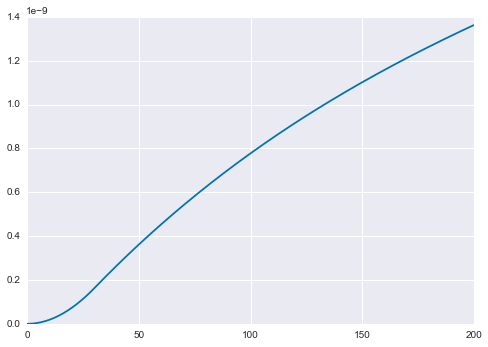

In [9]:
plt.plot(n2o_crf)

In [10]:
writer = pd.ExcelWriter('EPA N2O forcing 30 years.xlsx')
pd.DataFrame(n2o_crf).to_excel(writer)
writer.save()

## Calculation CO<sub>2</sub> in atmosphere following biomass combustion and regrowth (service life)

### Biomass uptake

When trying to determine what the behavior of an emission or uptake not accounted for in the standard CO<sub>2</sub> IRF, it is possible to convolute the two functions or arrays. Here the biomass growth function *g* is defined and normalized to an uptake of 1 kg. The function *g* starts at t=0 and ends at t=r.

(0, 90.0)

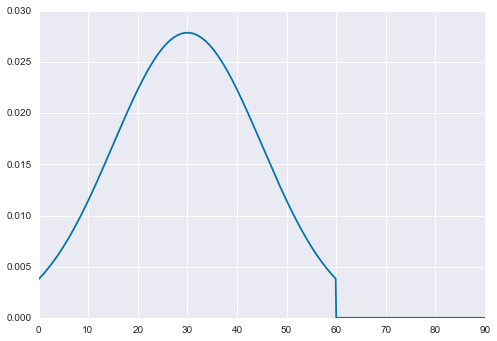

In [9]:
r=60. #rotation periods

g = 1/np.sqrt(2*np.pi*(r/4)**2)*np.exp(-((time-r/2)**2)/(2*(r/4)**2))
g[int(r/tstep):] = 0
g = g/sp.integrate.simps(g,dx=tstep) #normalizing uptake to 1

plt.plot(time,g)
plt.xlim(0, r+30)

From Cherubini (2011,2012) the amount of CO<sub>2</sub> in the air is modeled by convoluting the emission function (biomass combustion followed by the regrowth of that biomass) and the IRF. Cheubini 2011 represents the equation as $\int_0^t [C_0\delta(t')-g(t')]y(t-t')dt'$. This represents the atmospheric concentration at time $t-t'$ for emissions (or uptake) at time $t'$.

Because the delta function ($\delta$) is zero everywhere except at t=0 and we are modeling $C_0=1$, the equation above simplifies to $f(t)=y(t) - \int_0^t g(t')y(t-t')dt'$, which is the IRF minus the convolution of the IRF and the biomass growth. Because the biomass growth function is discontinuous it is easier to model by convoluting data points than the functions, which is done below.

The plot below shows the negative convolution of the IRF and biomass growth.

(0, 90.0)

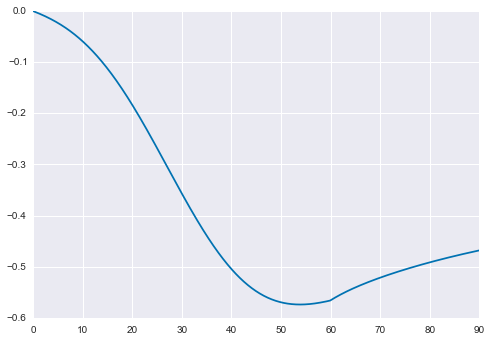

In [12]:
conv = np.resize(fftconvolve(CO2_AR5(time),g), time.size) * tstep 
plt.plot(time,-conv)
plt.xlim(0, r+30)

The plot below begins with 1kg of CO<sub>2</sub> in the air at t=0. Two different things happen as we move forward in time. The first is that the pulse of CO<sub>2</sub> is removed by the typical IRF decay. This happens on a slow time scale. The second is the uptake of CO<sub>2</sub> by the biomass, which has been modified by convolution with the IRF (see above). The convolution is done to account for outgassing from the ocean and other effects caused by the removal of CO<sub>2</sub> from the atmosphere through more than one route.

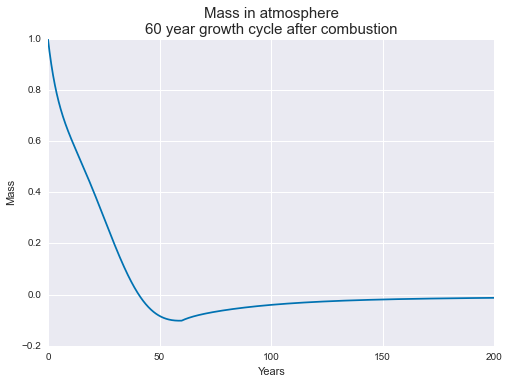

In [32]:
mass_after = CO2_AR5(time) - conv
plt.plot(time, mass_after)
plt.xlabel('Years')
plt.ylabel('Mass')
plt.title('Mass in atmosphere\n60 year growth cycle after combustion', size=15)

*F* is the cumulative integration of CO<sub>2</sub> in the atmosphere from combustion and regrowth

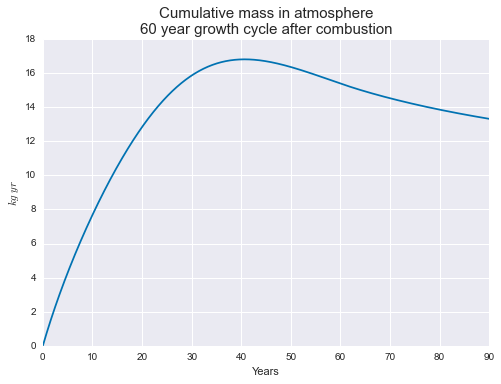

In [33]:
F_after = cumtrapz(result, dx=tstep, initial=0)
plt.plot(time, F_after)
plt.xlim(0, r+30)
plt.xlabel('Years')
plt.ylabel('$kg \ yr$')
plt.title('Cumulative mass in atmosphere\n60 year growth cycle after combustion', size=15)

A convolution of activity (one per year for 30 years) with the cumulative CO<sub>2</sub> gives the total cumulative atmospheric mass over time.

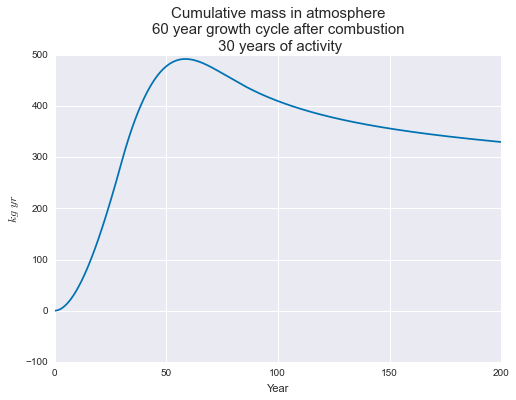

In [35]:
activity = np.ones_like(time)
activity[30/tstep + 1:] = 0

burn_grow = np.resize(fftconvolve(activity, F_after), time.size) * tstep
plt.plot(time, burn_grow)
plt.ylabel('$kg \ yr$', size=12)
plt.xlabel('Year')
plt.title('Cumulative mass in atmosphere\n60 year growth cycle after combustion\n 30 years of activity'
          , size=15)

## Calculation CO<sub>2</sub> in atmosphere following biomass growth and then combustion (service life)

Many of the same calculations from above can be used when modeling biomass growth followed by combustion. 

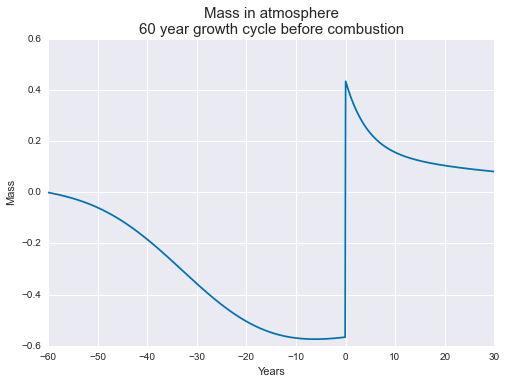

In [23]:
bioCO2 = -conv
combust_time = int(r/tstep)
f = np.zeros_like(time)
f[combust_time:] = np.resize(CO2_AR5(time), time[combust_time:].size)
mass_before = f + bioCO2
plt.plot(time - 60, mass_before)
plt.xlim(-60, 30)
plt.xlabel('Years')
plt.ylabel('Mass')
plt.title('Mass in atmosphere\n60 year growth cycle before combustion', size=15)

In [24]:
F_before = cumtrapz(mass_before, dx=tstep, initial=0)

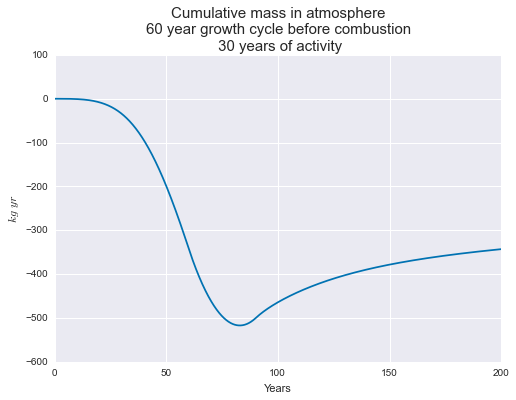

In [36]:
grow_burn = np.resize(fftconvolve(activity, F_before), time.size) * tstep
plt.plot(time, grow_burn)
plt.xlabel('Years')
plt.ylabel('$kg \ yr$', size=12)
plt.title('Cumulative mass in atmosphere\n60 year growth cycle before combustion\n 30 years of activity'
          , size=15)

## References

(1) Myhre, G.; Shindell, D.; Bréon, F.-M.; Collins, W.; Fuglestvedt, J.; Huang, J.; Koch, D.; Lamarque, J.-F.; Lee, D.; Mendoza, B.; et al. Anthropogenic and Natural Radiative Forcing. In Climate Change 2013: The Physical Science Basis. Contribution of Working Group I to the Fifth Assessment Report of the Intergovernmental Panel on Climate Change; Stocker, T. F., Qin, D., Plattner, G.-K., Tignor, M., Allen, S. K., Boschung, J., Nauels, A., Xia, Y., Bex, V., Midgley, P. M., Eds.; Cambridge University Press: Cambridge, United Kingdom and New York, NY, USA, 2013; pp 659–740.

(2) Boucher, O.; Friedlingstein, P.; Collins, B.; Shine, K. P. The indirect global warming potential and global temperature change potential due to methane oxidation. Environmental Research Letters 2009, 4 (4), 044007.

(3) Boucher, O.; Reddy, M. Climate trade-off between black carbon and carbon dioxide emissions. Energy Policy 2008, 36, 193–200.

(4) Collins, W. J.; Fry, M. M.; Yu, H.; Fuglestvedt, J. S.; Shindell, D. T.; West, J. J. Global and regional temperature-change potentials for near-term climate forcers. Atmos. Chem. Phys. 2013, 13 (5), 2471–2485.
